# Tests - ABCD


### Installing Julia and ABCD

We use the command line interface option to run ABCD below. 
The following steps are required:

* install Julia (we used version 1.7) from https://julialang.org/downloads/
* download ABCD from https://github.com/bkamins/ABCDGraphGenerator.jl
* adjust the 'abcd_path' in the next cell to the location of the 'utils' subdirectory of ABCD
* run 'julia abcd_path/install.jl' to install the required packages

Also set the path(s) in the cell below. For Windows, you may need to use "\\" or "\\\\" as delimiters, for example 'C:\ABCD\utils\\\\'

### Directories

* Set the directories accordingly in the next cell


In [1]:
## set those accordingly
abcd_path = '/work/home/fcthebe/ABCD/ABCDGraphGenerator.jl-master/utils/'
julia = '/work/home/fcthebe/julia-1.7.2/bin/julia'

## uncomment to get wide display
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import os
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns

## we use those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['white','gray','dimgray','black']

## ABCD with local and global $\mu$ 

1M nodes - this takes a few minutes

* global $\mu=0.3$ with Chung-Lu
* global $\mu=0.3$ with Configuration
* local $\mu=0.3$ with Chung-Lu (this mimics the behaviour of LFR)


In [3]:
%%time
seed = 27
mu = 0.3

## generate degree and community size values 
cmd = julia+' '+abcd_path+'deg_sampler.jl deg.dat 2.5 10 1000 1000000 1000 '+str(seed)
os.system(cmd+' >/dev/null 2>&1')
cmd = julia+' '+abcd_path+'com_sampler.jl cs.dat 1.5 1000 25000 1000000 1000 '+str(seed)
os.system(cmd+' >/dev/null 2>&1');
G = ig.Graph()

## generate graph given GLOBAL mu with CL
cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat mu '+str(mu)+' true false '+str(seed)
os.system(cmd+' >/dev/null 2>&1')
G[0] = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
## for plotting - color each community
G[0].vs['comm'] = [c[int(x['name'])-1]-1 for x in G[0].vs]

## generate graph given GLOBAL mu with CONFIG
cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat mu '+str(mu)+' false false '+str(seed)
os.system(cmd+' >/dev/null 2>&1')
G[1] = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
## for plotting - color each community
G[1].vs['comm'] = [c[int(x['name'])-1]-1 for x in G[1].vs]

## generate graph given LOCAL mu with CL
cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat mu '+str(mu)+' true true '+str(seed)
os.system(cmd+' >/dev/null 2>&1')
G[2] = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
## for plotting - color each community
G[2].vs['comm'] = [c[int(x['name'])-1]-1 for x in G[2].vs]

## NO LOCAL mu with CONFIG

## clean up
cmd = 'rm net.dat comm.dat'
os.system(cmd+' >/dev/null 2>&1');


CPU times: user 53.2 s, sys: 1.01 s, total: 54.2 s
Wall time: 2min 10s


In [4]:
%%time
flavours = ['global mu CL', 'global mu config', 'local mu CL']
df = pd.DataFrame()

for i in range(len(flavours)):
    g = G[i]
    I = []
    T = []
    S = []
    Wg = 2*g.ecount()
    g.vs['deg'] = g.degree()
    for j in range(max(g.vs['comm'])+1):
        sg = g.subgraph([v for v in g.vs if v['comm']==j])
        I.append(sum(sg.degree()))
        T.append(sum(sg.vs['deg']))
        S.append(sg.vcount())
    if i==0:
        df['size'] = S
    df[flavours[i]+' internal volumes'] = I
    df[flavours[i]+' volumes'] = T


CPU times: user 6min 8s, sys: 287 ms, total: 6min 9s
Wall time: 6min 9s


## corresponding $\xi$ with Chung-Lu 

Global only in this case


In [5]:
%%time
## xi = mu / (1-sum(W_i/W)**2)
Wg = 2*G[0].ecount()
xi = mu / (1 - sum( (df['global mu CL volumes']/Wg)**2 ))
## generate graph given GLOBAL xi
cmd = julia+' '+abcd_path+'graph_sampler.jl net.dat comm.dat deg.dat cs.dat xi '+str(xi)+' true false '+str(seed)
os.system(cmd+' >/dev/null 2>&1')
G[3] = ig.Graph.Read_Ncol('net.dat',directed=False)
c = np.loadtxt('comm.dat',dtype='uint16',usecols=(1))
## for plotting - color each community
G[3].vs['comm'] = [c[int(x['name'])-1]-1 for x in G[3].vs]
print('corresponding xi =',xi)

## clean up
cmd = 'rm net.dat comm.dat'
os.system(cmd+' >/dev/null 2>&1');

## global Chung-Lu with corresponding xi
g = G[3]
I = []
T = []
S = []
Wg = 2*g.ecount()
g.vs['deg'] = g.degree()
for i in range(max(g.vs['comm'])+1):
    sg = g.subgraph([v for v in g.vs if v['comm']==i])
    I.append(sum(sg.degree()))
    T.append(sum(sg.vs['deg']))
    S.append(sg.vcount())
df['global xi CL internal volumes'] = I
df['global xi CL volumes'] = T
df.head()


corresponding xi = 0.30347908190734996
CPU times: user 2min 22s, sys: 336 ms, total: 2min 23s
Wall time: 2min 48s


,size,global mu CL internal volumes,global mu CL volumes,global mu config internal volumes,global mu config volumes,local mu CL internal volumes,local mu CL volumes,global xi CL internal volumes,global xi CL volumes
0,24425,439730,624646,439898,624967,437486,625171,439856,624652
1,23988,435656,619298,435596,619142,433402,619051,435768,619316
2,22220,404802,574763,404496,575303,402864,574870,404448,574756
3,21523,385286,548649,385316,548293,383706,548175,385492,548620
4,21477,398732,567432,398626,567092,396922,567690,398796,567439


## Statistics

* **internal volumes**: sum of internal degree for each community
* **volumes**: sum of degree for each community
* **density**: ratio of number and maximal number of internal edges for each community
* **size**: number of nodes for each community


In [6]:
## overall proportions of external edges
print('global CL mu:',1- sum(df['global mu CL internal volumes'])/sum(df['global mu CL volumes']))
print('global config mu:',1- sum(df['global mu config internal volumes'])/sum(df['global mu config volumes']))
print('local CL mu:',1- sum(df['local mu CL internal volumes'])/sum(df['local mu CL volumes']))
print('global CL xi:',1- sum(df['global xi CL internal volumes'])/sum(df['global xi CL volumes']))


global CL mu: 0.3000644438962724
global config mu: 0.30010555680163664
local CL mu: 0.3000097303133301
global CL xi: 0.30006117973365365


### Global ABCD

Using the **global** variant of ABCD, we see that the proportion of internal edges is different for small vs large communities.

This is verified using $\mu$ or the equivalent $\xi$.

We also see no significant difference using the configuration model or Chung-Lu.


Correlation: -0.74843570525357


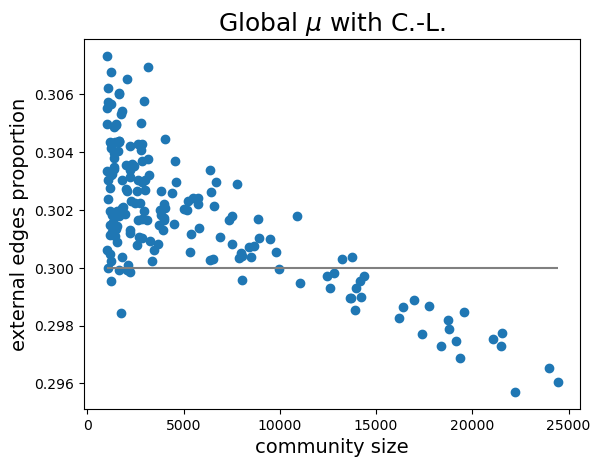

In [25]:
## mu global CL
plt.plot(df['size'] , 1 - df['global mu CL internal volumes'] / df['global mu CL volumes'], 'o')
plt.hlines(.3,min(df['size']),max(df['size']),color='grey')
plt.xlabel('community size', fontsize=14)
plt.ylabel('external edges proportion', fontsize=14)
plt.title(r'Global $\mu$ with C.-L.', fontsize=18)
print('Correlation:',np.corrcoef(df['size'] , 1 - df['global mu CL internal volumes'] / df['global mu CL volumes'])[0,1]);


Correlation: -0.7469799618865512


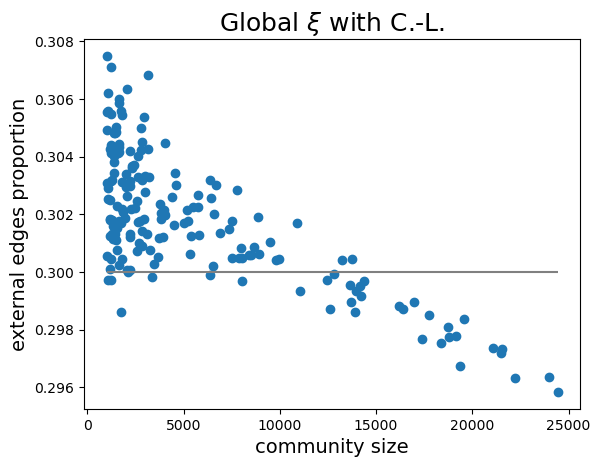

In [26]:
plt.plot(df['size'] , 1 - df['global xi CL internal volumes'] / df['global xi CL volumes'], 'o')
plt.hlines(.3,min(df['size']),max(df['size']),color='grey')
plt.xlabel('community size', fontsize=14)
plt.ylabel('external edges proportion', fontsize=14)
plt.title(r'Global $\xi$ with C.-L.', fontsize=18)
print('Correlation:',np.corrcoef(df['size'] , 1 - df['global xi CL internal volumes'] / df['global xi CL volumes'])[0,1]);


Correlation: -0.022022284894431473


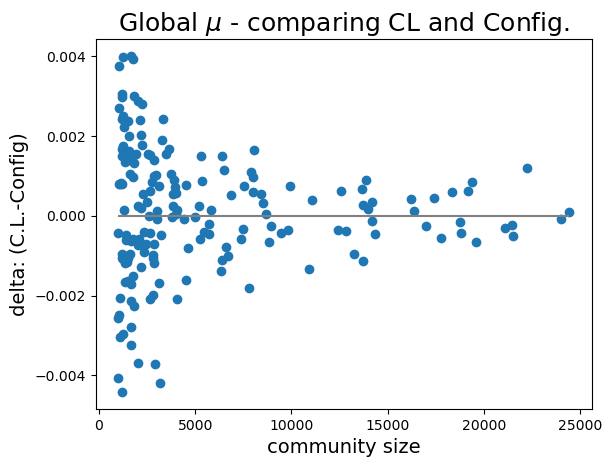

In [16]:
plt.plot(df['size'] , - df['global mu config internal volumes'] / df['global mu config volumes'] + df['global mu CL internal volumes'] / df['global mu CL volumes'] , 'o');
plt.xlabel('community size', fontsize=14)
plt.ylabel(r'delta: (C.L.-Config)', fontsize=14)
plt.title(r'Global $\mu$ - comparing CL and Config.', fontsize=18)
plt.hlines(0,min(df['size']),max(df['size']),color='grey')
print('Correlation:',np.corrcoef(df['size'] ,- df['global mu config internal volumes'] / df['global mu config volumes'] + df['global mu CL internal volumes'] / df['global mu CL volumes'] )[0,1])


### Local ABCD

Using the **local** variant of ABCD, which mimics the behaviour of **LFR**, we see that the proportion of internal edges is independent of community size (as expected, there is more variability with small communities).


Correlation: 0.04719569088234601


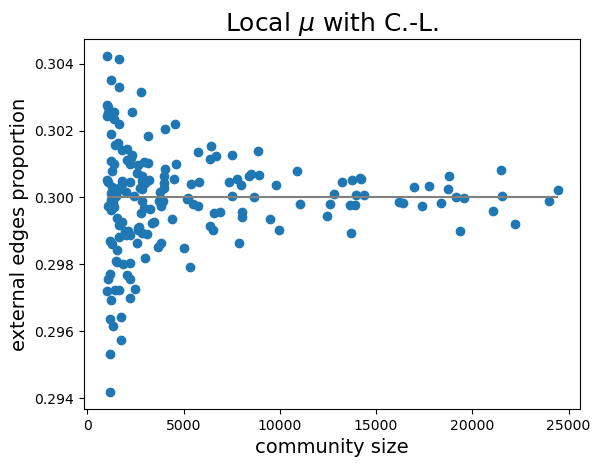

In [27]:
plt.plot(df['size'] , 1 - df['local mu CL internal volumes'] / df['local mu CL volumes'], 'o');
plt.hlines(.3,min(df['size']),max(df['size']),color='grey')
plt.xlabel('community size', fontsize=14)
plt.ylabel('external edges proportion', fontsize=14)
plt.title(r'Local $\mu$ with C.-L.', fontsize=18)
print('Correlation:',np.corrcoef(df['size'] , 1 - df['local mu CL internal volumes'] / df['local mu CL volumes'])[0,1])


### Density vs size

One effect of using the local variant (LFR-like) is that small communities will have higher density. 

In the plots below, we illustrate this by plotting the **difference** and the **ratio** in density between the two variants as a function of community size.


Correlation: -0.746939245272192


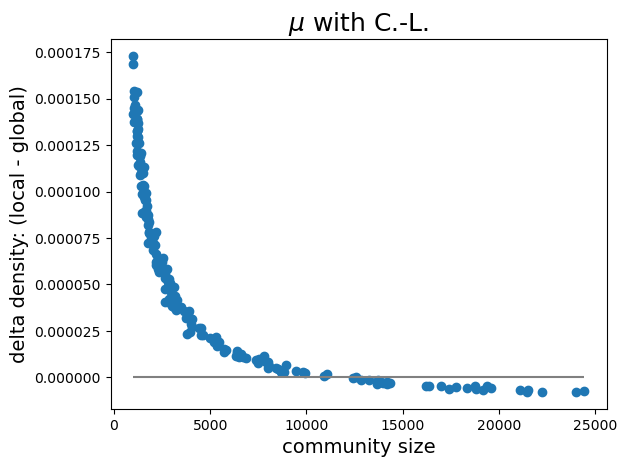

In [11]:
density_local = df['local mu CL internal volumes'] / (df['size']*(df['size']-1)/2)
density_global = df['global mu CL internal volumes'] / (df['size']*(df['size']-1)/2)


plt.plot(df['size'] , density_local-density_global, 'o');
plt.xlabel('community size', fontsize=14)
plt.ylabel('delta density: (local - global)', fontsize=14)
plt.title(r'$\mu$ with C.-L.', fontsize=18)
plt.hlines(0,min(df['size']),max(df['size']),color='grey')
print('Correlation:',np.corrcoef(df['size'] , density_local-density_global)[0,1])


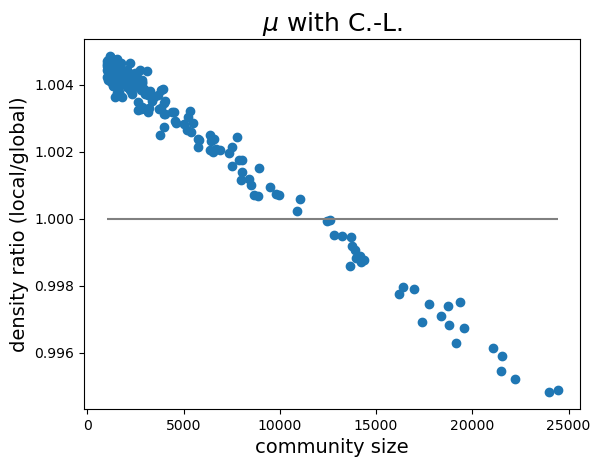

In [12]:
plt.plot(df['size'] , density_local/density_global, 'o');
plt.xlabel('community size', fontsize=14)
plt.ylabel('density ratio (local/global)', fontsize=14)
plt.hlines(1,min(df['size']),max(df['size']),color='grey')
plt.title(r'$\mu$ with C.-L.', fontsize=18);


In [13]:
## clean up
cmd = 'rm deg.dat cs.dat net.dat comm.dat'
os.system(cmd+' >/dev/null 2>&1');
